# Aligning phonemes and words to audio

In this notebook we demonstrate how to perform alignment between audio and text transcripts of a series of trials. We show two methods for performing this alignment. 

1) All the information needed for alignment can be stored in an OutStruct, including the sound waveform, text transcripts, and several other parameters, and the entire alignment is performed on the outstruct object, returning a new OutStruct which has alignment information.
    
2) WAV files and .txt files for all trials are stored in specific directories and alignment is performed in 2 steps. First, these files are aligned to create .TextGrid, .phn, and .wrd files. Then these are processed to create the same alignment information as is output by method 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import naplib as nl

In [2]:
outstruct = nl.io.load('../Alignment/out_NY834_small.pkl')
len(outstruct) # number of trials in this outstruct

240

## Method 1: Perform full alignment pipeline om an OutStruct

All sounds and transcripts as well and several other fields must be present in the outstruct. They will be aligned and results will be given in a new outstruct of label vectors.

In [5]:
# Specify the directory to store the output files from alignment (.TextGrid, .phn, and .wrd files)
output_dir = './alignment_output_outstruct'

aligner = nl.alignment.Aligner(output_dir)

In [17]:
# the Aligner's align() method requires a length field which specifies the number of
# samples that we want each resulting label vector to contain
outstruct['length'] = [x.shape[0] for x in outstruct['resp']]

The "sound" field is type <class 'numpy.ndarray'> and the first trial is shape (150760,)


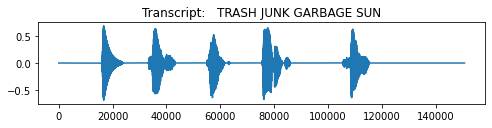

In [25]:
# Two of the other critical fields we need for alignment include the 'sound', and the 'transcript'
print(f'The "sound" field is type {type(outstruct[0]["sound"])} and the first trial is shape {outstruct[0]["sound"].shape}')

plt.figure(figsize=(8,1.5))
plt.plot(outstruct[0]["sound"])
plt.title(f'Transcript:   {outstruct[0]["script"]}')
plt.show()


In [26]:
# This is the first trial's 'transcript', the words spoken in the trial's stimulus
outstruct[0]["script"]

'TRASH JUNK GARBAGE SUN'

In [6]:
# In this outstruct, the transcript is in a field called "script", not the default "transcript",
# so we need to specify that.
# If other required fields were named differently from their default values, we would need
# to specify those as well. See documentation for details of required fields.

result = aligner.align(outstruct, transcript='script') # perform alignment

Resampling audio and putting in data_/ directory...
Converting text files to ascii in data_/ directory...
Performing alignment...
Converting .TextGrid files to .phn and .wrd in ./alignment_output_outstruct
Finished creating alignment files.
Creating label vectors for phonemes, manner of articulation, and words.


### Use a custom dictionary for phonemes

If there were words in our scripts that were not in the default dictionary, we can create our own dictionary file
by copying the [ProsodyLab eng.dict](https://github.com/prosodylab/Prosodylab-Aligner/blob/master/eng.dict) and adding lines for the words that we need. We can then put this new .dict file in the current path and specify it for the Aligner to use.

In [7]:
aligner = nl.alignment.Aligner(output_dir, dictionary_file='../Alignment/eng_modified.dict')

result = aligner.align(outstruct, transcript='script')

Resampling audio and putting in data_/ directory...
Converting text files to ascii in data_/ directory...
Performing alignment...
Converting .TextGrid files to .phn and .wrd in ./alignment_output_outstruct
Finished creating alignment files.
Creating label vectors for phonemes, manner of articulation, and words.


## Method 2: Perform alignment using audio and text files

If we have the sounds and transcripts in files but not in our OutStruct, we can put all sounds (.wav files) in one directory and all matching transcripts (.txt files) in another directory.

In [8]:
audio_dir = '../Alignment/sounds'
text_dir = '../Alignment/scripts'
output_dir = './alignment_output'

In [9]:
aligner = nl.alignment.Aligner(output_dir)

aligner.align_files(audio_dir, text_dir)

Resampling audio and putting in data_/ directory...
Converting text files to ascii in data_/ directory...
Performing alignment...
Converting .TextGrid files to .phn and .wrd in ./alignment_output
Finished creating alignment files.


#### Let's look at some of the files that were created in the output_dir

In [10]:
!ls ./alignment_output | head -10

block-0-audio-00.TextGrid
block-0-audio-00.phn
block-0-audio-00.wrd
block-0-audio-01.TextGrid
block-0-audio-01.phn
block-0-audio-01.wrd
block-0-audio-02.TextGrid
block-0-audio-02.phn
block-0-audio-02.wrd
block-0-audio-03.TextGrid


### Create array of phoneme and word labels across time for each trial from the created files

Now, we use the information in the .phn and .wrd files to generate an array of labels which shows what phoneme or word is currently happening at each point in time for each trial in our outstruct. We specify a different 'befaft' because the .wav files we have in the directories don't include the befaft period.

In [11]:
result = aligner.get_label_vecs_from_files(outstruct, befaft=np.array([2,1]))

Creating label vectors for phonemes, manner of articulation, and words.


## Visualize the label vectors we created from either method

Using either method 1 or method 2, we are left with an OutStruct containing fields with the alignment information. We can visualize the label vectors for phonemes, manner of articulation, and words over time for a few trials. For each trial, the sound consists of a beep followed by 4 words.

In [12]:
result.fields

['phn_labels',
 'manner_labels',
 'wrd_labels',
 'phn_label_list',
 'manner_label_list',
 'wrd_dict']

Trial 0


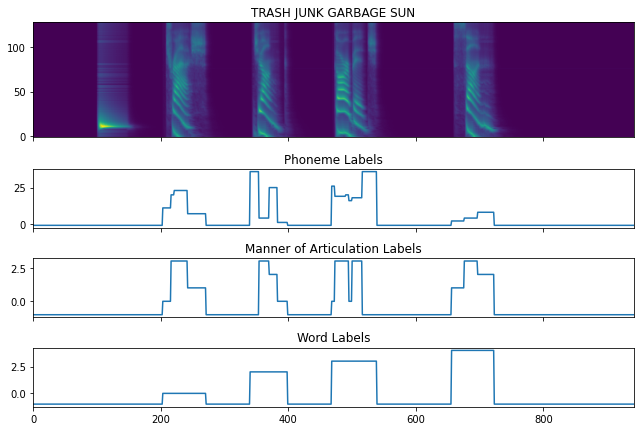

Trial 1


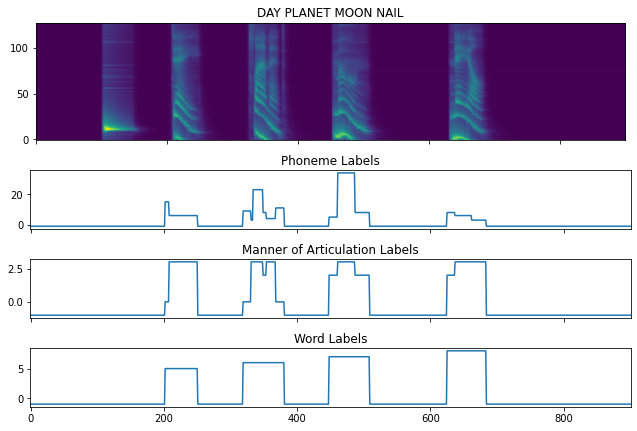

Trial 2


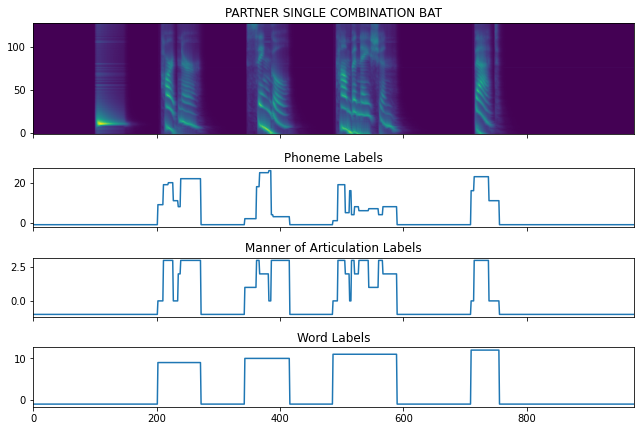

In [16]:
# Let's just look at the first 3 trials of label vectors aligned to the stimulus
for n, trial in enumerate(outstruct[:3]):
    
    print(f'Trial {n}')
    
    fig, axes = plt.subplots(4,1,figsize=(9,6), sharex=True, gridspec_kw={'height_ratios':[2,1,1,1]})
    
    axes[0].imshow(trial['aud'].T**.3, origin='lower', aspect=1.4)
    axes[0].set_title(trial['script'])
    
    axes[1].plot(result['phn_labels'][n])
    axes[1].set_title('Phoneme Labels')
    
    axes[2].plot(result['manner_labels'][n])
    axes[2].set_title('Manner of Articulation Labels')
    
    axes[3].plot(result['wrd_labels'][n])
    axes[3].set_title('Word Labels')
    
    plt.tight_layout()
    
    plt.show()


## Looking at responses to word onsets

One simple thing we can look at using these label vectors is the neural response to word onsets.

In [11]:
segments, labels, prior_labels = nl.segmentation.segment_around_labeltransitions(outstruct, data='resp', labels=result['wrd_labels'], prechange_samples=50, postchange_samples=200)

print((segments.shape, labels.shape, prior_labels.shape))


((1920, 250, 8), (1920,), (1920,))


We segmented the data into places where the word label changed. We only want to look at the segments where the word label changed from -1 (no word) to something, so we select only the segments where the label for that segment is > -1


In [12]:
segments = segments[labels>-1]
segments.shape

(960, 250, 8)

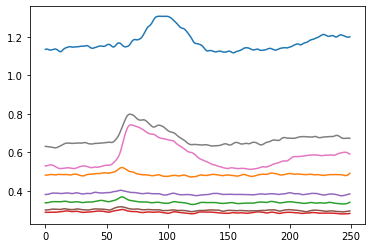

In [13]:
# plot the average word-onset response for each electrode
plt.figure()
plt.plot(segments.mean(0))
plt.show()